In [1]:
from netCDF4 import Dataset
from glob import glob
import os, sys

is_py = os.path.basename(sys.argv[0]) == 'vert_contour.ju.py'
RUN_ID = int(sys.argv[1]) if is_py and len(sys.argv) > 1 else 9

root_dir = '/home/guc/'
data_dir = f'runs/{RUN_ID:03}*/'
root_data_dir = glob(root_dir + data_dir)[0]

image_dir = root_data_dir + 'results/images/'
if len(glob(image_dir)) == 0:
    os.mkdir(image_dir)

dataset = Dataset(glob(root_data_dir + 'wrfout*')[0])

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from wrf import getvar, to_np, extract_times, ALL_TIMES, vertcross, CoordPair

plt.rcParams["font.family"] = "DejaVu Sans Mono"

# === EDIT COORDS HERE ===
START = (30.5, 140) # Y, X
END = (39, 140) # Y, X

start_point = CoordPair(lat = START[0], lon = START[1])
end_point = CoordPair(lat = END[0], lon = END[1])

var_data_template = getvar(dataset, "wa", timeidx=0)
z_data_template = getvar(dataset, "z", timeidx=0)
var_template = vertcross(
    var_data_template,
    z_data_template,
    wrfin=dataset,
    timeidx=0,
    start_point=start_point,
    end_point=end_point,
    latlon=True,
    meta=True
)
var_cross_means = np.zeros(var_template.shape)

In [3]:
times = extract_times(dataset, timeidx=ALL_TIMES)
vert_levels = np.linspace(0, 20000, 200)

for time_idx, datetime in enumerate(times):
    print(f'Processing time {datetime}', end='\r')
    var_data = getvar(dataset, "wa", timeidx=time_idx)
    z_data = getvar(dataset, "z", timeidx=time_idx)
    var_cross = vertcross(
        var_data,
        z_data,
        levels=vert_levels,
        wrfin=dataset,
        timeidx=time_idx,
        start_point=start_point,
        end_point=end_point,
        latlon=True,
        meta=True
    )
    if time_idx == 0:
        var_cross_means = np.abs(to_np(var_cross))
    else:
        var_cross_means += np.abs(to_np(var_cross))

Text(0.5, 1.0, 'Average Vertical Wind Speed (m/s) Cross Section, Real Model,\n Urban Grassland (AHE=1000)')

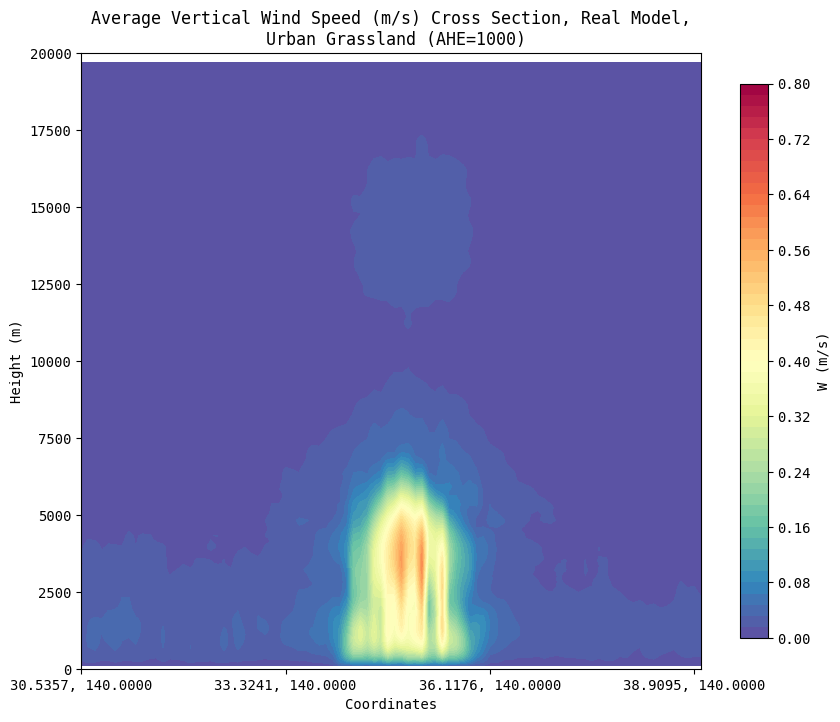

In [6]:
plt.figure(figsize=(10, 8)) # width, height
ax = plt.axes()

plot_lim = np.linspace(0, 0.8, 51)

vert_vals = to_np(var_template.coords["vertical"])
coord_pairs = to_np(var_template.coords['xy_loc'])
coord_pair_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
ax.set_xticks(np.arange(coord_pairs.shape[0])[::30])
# ax.set_yticks(np.arange(vert_vals.shape[0])[::10])
# ax.set_yticklabels(vert_vals[::10])

plt.ylabel('Height (m)')
plt.xlabel('Coordinates')
plt.contourf(coord_pair_labels, vert_levels, var_cross_means / len(times), plot_lim, cmap="Spectral_r")
cbar = plt.colorbar(shrink=.9, ticks=plot_lim[::5])
cbar.ax.set_ylabel('W (m/s)')
plt.title(f"Average Vertical Wind Speed (m/s) Cross Section, Real Model,\n Urban Grassland (AHE=1000)")

# plt.savefig('/home/guc/results/w-contour-ahe-1000.png')